In [152]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine as p9

All the files we need are saved in the cluster. Specifically, we have the following tables:

```{bash}
module load bio
srun --pty -p staclass bash -i
sqlite> .tables
agency                         subtier_agency               
awards                         toptier_agency               
recipient_lookup               universal_transaction_matview
state_data    
```

The agency table has a toptier_agency pointer for each and every agency. This will help us determine the general function of a given agency. We can look at the schema of agency table:

```{bash}
sqlite> .schema agency
CREATE TABLE `agency` (
  `id` INTEGER,
  `create_date` REAL,
  `update_date` REAL,
  `toptier_flag` INTEGER,
  `office_agency_id` INTEGER,
  `subtier_agency_id` INTEGER,
  `toptier_agency_id` INTEGER
);
```

The universal_transaction_matview keeps the records of the transactions/modifications on awards. However, there seem to be problems of duplicates. We can query those duplicates:

```{bash}
sqlite -header -csv /scratch/usaspending.sqlite "SELECT a.* FROM universal_transaction_matview a
JOIN (SELECT action_date, fiscal_year, total_obligation, awarding_agency_id, funding_agency_id, count(*)
FROM universal_transaction_matview
GROUPBY action_date, fiscal_year, total_obligation, awarding_agency_id, funding_agency_id
HAVING count(*) > 1 ) b
ON a.action_date = b.action_date
AND a.fiscal_year = b.fiscal_year
AND a.total_obligation = b.total_obligation
AND a.awarding_agency_id = b.awarding_agency_id
AND a.funding_agency_id = b.awarding_agency_id;" > dupes.csv
```

The assumptions of duplicates are having the same action_date, fiscal_year, total_obligation, awarding_agency_id and funding_agency_id. Looking at those exmaples, we find that they usually occur when generated_pragmatic_obligations are different. However, the summary data from the seemingly distinct transaction does not add up. As a result, we decided to move forward with awards table.

Next, we pulled the annual spending for each agency from awards table and saved the data to agg_awards:

```{bash}
# generates aggregated annual spending for each awarding/funding agency
sqlite3 -header -csv /scratch/usaspending.sqlite "SELECT fiscal_year, awarding_agency_id, funding_agency_id,
SUM(total_obligation) as annual_spending
FROM awards
GROUP BY fiscal_year, awarding_agency_id, funding_agency_id;" > agg_awards.csv
```


```{bash}
# Pulling data from database tables and saving them to local csv files
sqlite3 -header -csv /scratch/usaspending.sqlite "SELECT * FROM agency;" > agency.csv
```
```{bash}
sqlite3 -header -csv /scratch/usaspending.sqlite "SELECT * FROM toptier_agency;" > toptier_agency.csv
```

The toptier_agency contains information on 157 "bigger" agencies. The idea is that we can label those 157 agencies with specific funtions and see how they might be different under different political powers. 

We used the "Classification of the Functions of Government" or COFOG, which is a classification defined by the United Nations Statistics Division. It divides agencies into 10 different general functions. These are:

    General public services
    Defence
    Public order and safety
    Economic affairs
    Environmental protection
    Housing and community amenities
    Health
    Recreation, culture and religion
    Education
    Social protection

See https://en.wikipedia.org/wiki/Classification_of_the_Functions_of_Government.

The classification is carried out using standards provided by https://www.imf.org/external/pubs/ft/gfs/manual/pdf/ch6ann.pdf

We added a new columnn "COFOG" to toptier_agency table. The numbers (1-10) correspond to the functions specified in https://en.wikipedia.org/wiki/Classification_of_the_Functions_of_Government.


In [128]:
# join agency table and toptier_agency table. 
agency = pd.read_csv('agency.csv')
toptier_agency = pd.read_csv('toptier_agency.csv')
left_cols = ['id', 'toptier_agency_id']
right_cols = ['toptier_agency_id', 'name', 'COFOG']
agency_category = agency[left_cols].merge(toptier_agency[right_cols], how='left', on='toptier_agency_id')
agency_category.columns = ['id', 'toptier_agency_id', 'toptier_agency_name', 'COFOG']
agency_category['COFOG_name'] = agency_category['COFOG']
# map the COFOG numbers to the actual names
agency_category.loc[agency_category['COFOG'] == 1, 'COFOG_name'] = 'General public services'
agency_category.loc[agency_category['COFOG'] == 2, 'COFOG_name'] = 'Defense'
agency_category.loc[agency_category['COFOG'] == 3, 'COFOG_name'] = 'Public order and safety'
agency_category.loc[agency_category['COFOG'] == 4, 'COFOG_name'] = 'Economic affairs'
agency_category.loc[agency_category['COFOG'] == 5, 'COFOG_name'] = 'Environmental protection'
agency_category.loc[agency_category['COFOG'] == 6, 'COFOG_name'] = 'Housing and community services'
agency_category.loc[agency_category['COFOG'] == 7, 'COFOG_name'] = 'Health'
agency_category.loc[agency_category['COFOG'] == 8, 'COFOG_name'] = 'Recreation, culture and religion'
agency_category.loc[agency_category['COFOG'] == 9, 'COFOG_name'] = 'Education'
agency_category.loc[agency_category['COFOG'] == 10, 'COFOG_name'] = 'Social protection'
# save the dataframe to csv
agency_category.to_csv('agency_category.csv')
# examples
agency_category.tail()

,id,toptier_agency_id,toptier_agency_name,COFOG,COFOG_name
1467,1468,156,Temporary Commissions,2.0,Defense
1468,1469,156,Temporary Commissions,2.0,Defense
1469,1470,156,Temporary Commissions,2.0,Defense
1470,1471,157,Resolution Funding Corporation,4.0,Economic affairs
1471,1472,157,Resolution Funding Corporation,4.0,Economic affairs


Now we can join agg_awards, which has the annual spending of each agency, together with agency_category.

In [130]:
agg_awards = pd.read_csv('agg_awards.csv')
agg_awards = agg_awards.fillna(0)
agency_award = agg_awards.merge(agency_category, how='left', left_on='awarding_agency_id', right_on='id')
agency_award.tail()

,fiscal_year,awarding_agency_id,funding_agency_id,annual_spending,id,toptier_agency_id,toptier_agency_name,COFOG,COFOG_name
20843,2018.0,1235.0,1173.0,1.598721e+05,1235.0,126.0,Department of Defense,2.0,Defense
20844,2018.0,1235.0,1174.0,2.925172e+07,1235.0,126.0,Department of Defense,2.0,Defense
20845,2018.0,1235.0,1188.0,3.554958e+07,1235.0,126.0,Department of Defense,2.0,Defense
20846,2018.0,1235.0,1235.0,1.893940e+09,1235.0,126.0,Department of Defense,2.0,Defense
20847,2018.0,1423.0,0.0,1.320119e+07,1423.0,136.0,Institute of Museum and Library Services,8.0,"Recreation, culture and religion"


Finally, we can calculate the annual percentages of each function (category) to the total annual spendings.

In [133]:
# calculates the annual percentages of each function relative to that year's total annual spending 
category_award = agency_award.groupby(['fiscal_year', 'COFOG_name']).agg({'annual_spending': np.sum}).reset_index()
category_percent_array = category_award['annual_spending'] / category_award.groupby(['fiscal_year'])['annual_spending'].transform('sum')
d = {'fiscal_year': category_award['fiscal_year'],
    'COFOG_name': category_award['COFOG_name'],
    'percent': category_percent_array}
category = pd.DataFrame(data=d)
# keeping the summarized data after 2001 (including)
category = category[category['fiscal_year'] > 2000]
category.tail()

,fiscal_year,COFOG_name,percent
209,2018.0,Health,0.332441
210,2018.0,Housing and community services,0.010356
211,2018.0,Public order and safety,0.028878
212,2018.0,"Recreation, culture and religion",0.000461
213,2018.0,Social protection,0.083891


The initial plot shows some variations across all functions from 2001-2018.

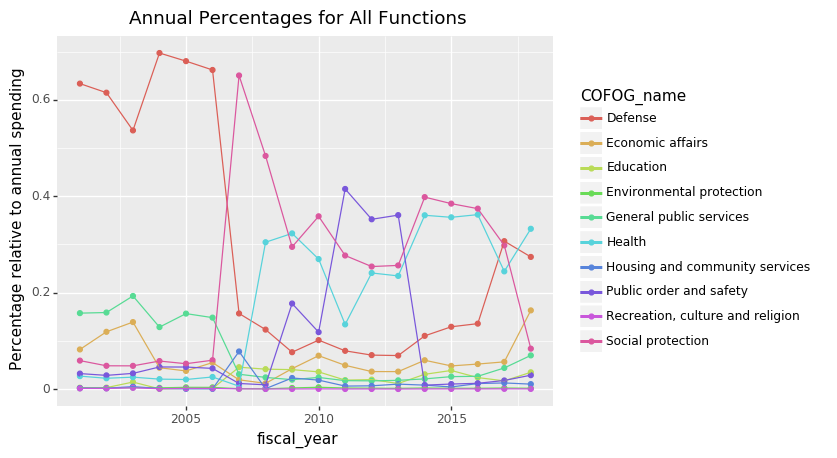

<ggplot: (309250368)>

In [155]:
ggplot(category)\
+ aes('fiscal_year', "percent", group='COFOG_name', color="COFOG_name")\
+ geom_point() + geom_line()\
+ p9.labels.ylab('Percentage relative to annual spending')\
+ p9.labels.ggtitle("Annual Percentages for All Functions")

The noticable categories are defense, econmic affairs, general public services, public order & safety, health and social protection. Plotting those categories:

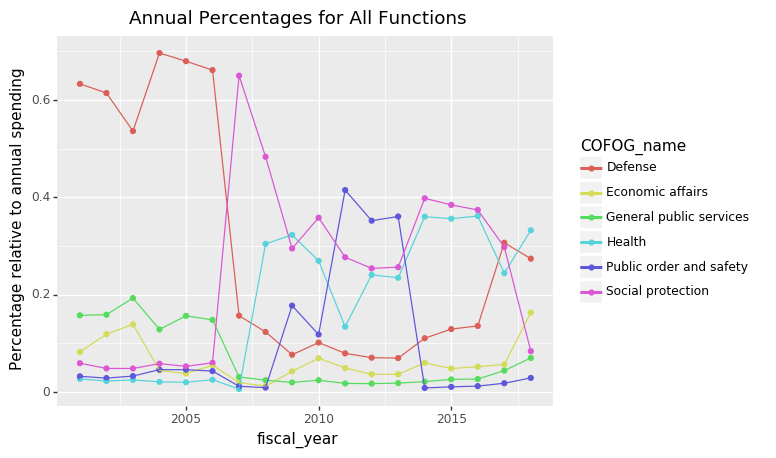

<ggplot: (310001142)>

In [177]:
temp_df = category[category['COFOG_name'].str.contains(
    "Defense|Economic affairs|General public services|Public order and safety|Health|Social protection")]
ggplot(temp_df)\
+ aes('fiscal_year', "percent", group='COFOG_name', color="COFOG_name")\
+ geom_point() + geom_line()\
+ p9.labels.ylab('Percentage relative to annual spending')\
+ p9.labels.ggtitle("Annual Percentages for All Functions")

Its worth pointing out that data before 2009 appears to be incomplete, which might explains an unusual high amount of spending on defense:

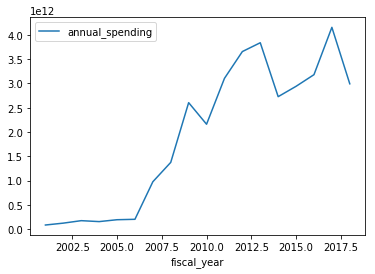

In [176]:
annual_spending_by_year = agg_awards.groupby(['fiscal_year']).agg({'annual_spending': np.sum}).reset_index()
annual_spending_by_year = annual_spending_by_year[annual_spending_by_year['fiscal_year'] > 2000]
annual_spending_by_year.plot(x='fiscal_year', y='annual_spending')

A closer look at functions that are relatively little in terms of percentages to total spending each year:

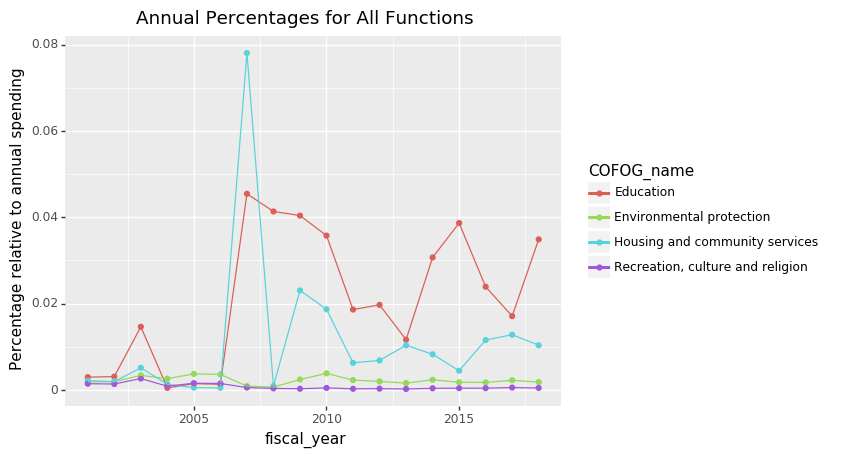

<ggplot: (-9223372036545656530)>

In [178]:
temp_df = category[category['COFOG_name'].str.contains(
    "Education|Environmental protection|Housing and community services|Recreation")]
ggplot(temp_df)\
+ aes('fiscal_year', "percent", group='COFOG_name', color="COFOG_name")\
+ geom_point() + geom_line()\
+ p9.labels.ylab('Percentage relative to annual spending')\
+ p9.labels.ggtitle("Annual Percentages for All Functions")

To see how political power affect spendings, we prepared a table (parties) to indicate which political party is in power in terms of house, senate and president. For example, republicans (R) had the majority seating in senate in 2018, whereas democrats (D) had the majority seating in house.

In [193]:
parties = pd.read_csv('parties.csv')
parties = parties[(parties['year'] > 2008) & (parties['year'] < 2019)]
parties

,year,house,senate,president
9,2009,D,D,D
10,2010,D,D,D
11,2011,R,D,D
12,2012,R,D,D
13,2013,R,D,D
14,2014,R,D,D
15,2015,R,R,D
16,2016,R,R,D
17,2017,R,R,R
18,2018,R,R,R


Immediately, we noticed a postive relationship between republican party in power and its abnormally high amount of spendings in millitary (defense) before 2007. This is likely due to data quality issue, since data before 2009 seems to be incomplete in in terms of the scales of total spending (total spending was below 1.5 trillion before 2009). Moving forward, we focused on the data after 2009.

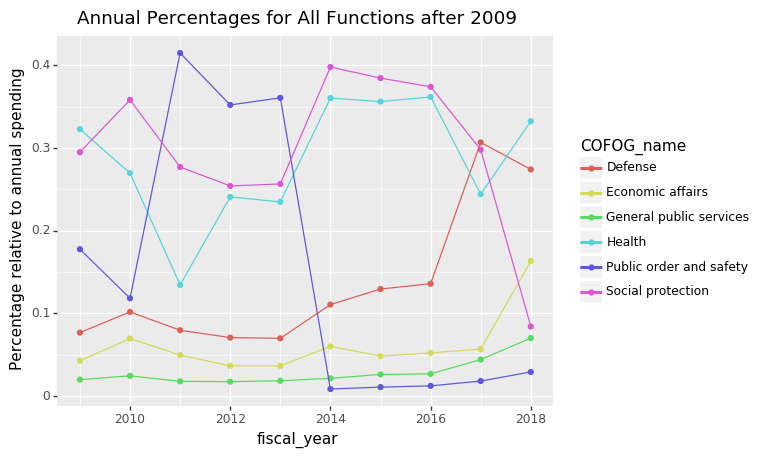

<ggplot: (-9223372036545337547)>

In [188]:
test_df = category[category['fiscal_year'] > 2008]
temp_df = test_df[test_df['COFOG_name'].str.contains(
    "Defense|Economic affairs|General public services|Public order and safety|Health|Social protection")]
ggplot(temp_df)\
+ aes('fiscal_year', "percent", group='COFOG_name', color="COFOG_name")\
+ geom_point() + geom_line()\
+ p9.labels.ylab('Percentage relative to annual spending')\
+ p9.labels.ggtitle("Annual Percentages for All Functions after 2009")

Some initial finding: 

    Spending on defense was noticeably higher after 2015, especially in 2017.
    Spending on economics is relatively stable.
    Noticeable drop in health and social protection since 2016.

We can generalize the power as who has 2/3 or above majority control in house, senate and president (???). There is a clear cut where democrats had 2/3 or above control before 2015 and republicans had 2/3 or above control after 2015.

In [226]:
# keep data from 2009 to 2018. Assign 'D' to rows before 2015 and 'R' to rows starting 2015.
category_award = category_award[(category_award['fiscal_year'] > 2008) & (category_award['fiscal_year'] < 2019)]
def f(row):
    if row['fiscal_year'] < 2015:
        val = 'D'
    else:
        val = 'R'
    return val

category_award['in_power'] = category_award.apply(f, axis=1)
before_after_2015 = category_award.groupby(['COFOG_name', 'in_power']).agg({'annual_spending': np.sum}).reset_index()
before_after_2015.columns = ['COFOG_name', 'in_power', 'total_spending']
percent_array = before_after_2015['total_spending'] / before_after_2015.groupby(['in_power'])['total_spending'].transform('sum')

d = {'COFOG_name': before_after_2015['COFOG_name'],
    'in_power': before_after_2015['in_power'],
    'percent': percent_array}
before_after_2015 = pd.DataFrame(data=d)

We can see how different categories changed before and after 2015:

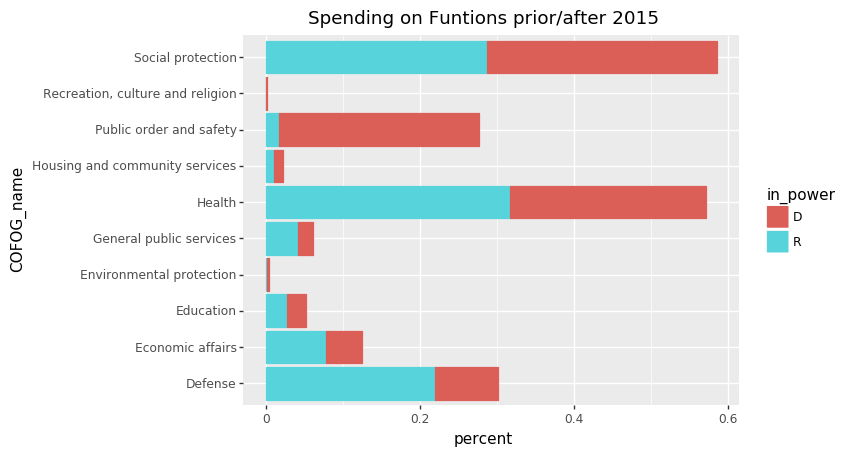

<ggplot: (310407183)>

In [258]:
ggplot(before_after_2015)\
+ aes('COFOG_name', 'percent', color = 'in_power', fill='in_power') + geom_col()\
+ coord_flip()\
+ p9.labels.ggtitle("Spending on Funtions prior/after 2015")